In [1]:
import pandas as pd
import numpy as np
import pyupbit
import psycopg2
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgb

## Load Dataset
-----------------

In [2]:
# # Get data using upbit api
# df = pyupbit.get_ohlcv("KRW-ETH", interval="minute1", count=106200)
# df.rename_axis("datetime", inplace=True)
# df.to_csv("krw_eth_upbit.csv")

In [3]:
# # Get data from imhs db
# t_port = 5432

# connection = psycopg2.connect(host=t_host, dbname=t_dbname, user=t_user, password=t_passwsrd, port=t_port)
# cursor = connection.cursor()
# sql = """
#     SELECT *
#     FROM coin_candles
# """
# cursor.execute(sql)
# df = pd.DataFrame(cursor.fetchall(), columns = ["market", "datetime", "open", "high", "low", "close", "volume", "value"])
# df.set_index("datetime", inplace=True)
# df.to_csv("krw_eth_imhsdb.csv")

In [4]:
# Get data from a saved file
df = pd.read_csv("krw_eth_upbit.csv", index_col="datetime")
# df = pd.read_csv("krw_eth_imhsdb.csv", index_col="datetime")

In [5]:
# df1 = pd.read_csv("krw_eth_upbit.csv", index_col="datetime")
# df1 = df1.add_prefix("api_")
# df2 = pd.read_csv("krw_eth_imhsdb.csv", index_col="datetime")
# df3 = df2.join(df1, how="left")

## Generate Features
---------------

In [6]:
def get_stochastic_fast_k(close_price, low, high, n=5):
    fast_k = ((close_price - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return fast_k

# Slow %K = Fast %K의 m기간 이동평균(SMA)
def get_stochastic_slow_k(fast_k, n=3):
    slow_k = fast_k.rolling(n).mean()
    return slow_k

# Slow %D = Slow %K의 t기간 이동평균(SMA)
def get_stochastic_slow_d(slow_k, n=3):
    slow_d = slow_k.rolling(n).mean()
    return slow_d

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

def get_rsi(price, period=14):
    delta = price.diff()
    gains, declines = delta.copy(), delta.copy()
    gains[gains < 0] = 0
    declines[declines > 0] = 0
    
    _gain = gains.ewm(com=(period-1), min_periods=period).mean()
    _loss = declines.abs().ewm(com=(period-1), min_periods=period).mean()
    RS = _gain / _loss
    
    return pd.Series(100 - (100/(1+RS)), name = 'RSI')

In [7]:
ft = df[["open", "high", "low", "close", "volume", "value"]].copy()

## MA: 이동평균선
ft['MA5'] = ft['close'].rolling(window=5).mean()
ft['MA20'] = ft['close'].rolling(window=20).mean()
ft['MA60'] = ft['close'].rolling(window=60).mean()
# ft['MA200'] = ft['Close'].rolling(window=200).mean()

ft['stddev'] = ft['close'].rolling(window=20).std() # 20일 이동표준편차
ft['upper'] = ft['MA20'] + 2*ft['stddev'] # 상단밴드
ft['lower'] = ft['MA20'] - 2*ft['stddev'] # 하단밴드
ft['upper-lower'] = ft['upper']-ft['lower']

ft['MA20-MA5'] = ft['MA20'] - ft['MA5']
ft['MA60-MA20'] = ft['MA60'] - ft['MA20']

# MACD
macd_short, macd_long, macd_signal=12,26,9 #기본값
ft["MACD_short"]=ft['close'].ewm(span=macd_short).mean()
ft["MACD_long"]=ft['close'].ewm(span=macd_long).mean()
ft["MACD"]=ft.apply(lambda x: (x["MACD_short"]-x["MACD_long"]), axis=1)
ft["MACD_signal"]=ft["MACD"].ewm(span=macd_signal).mean()  
ft["MACD_oscillator"]=ft.apply(lambda x:(x["MACD"]-x["MACD_signal"]), axis=1)
ft["MACD_sign"]=ft.apply(lambda x: ("매수" if x["MACD"]>x["MACD_signal"] else "매도"), axis=1)

# fast_k, slow_k, slow_d를 획득
ft['fast_k5'] = get_stochastic_fast_k(ft['close'], ft['low'], ft['high'], 5)
ft['slow_k3'] = get_stochastic_slow_k(ft['fast_k5'], 3)
ft['slow_d3'] = get_stochastic_slow_d(ft['slow_k3'], 3)

ft['fast_k10'] = get_stochastic_fast_k(ft['close'], ft['low'], ft['high'], 10)
ft['slow_k6'] = get_stochastic_slow_k(ft['fast_k10'], 6)
ft['slow_d6'] = get_stochastic_slow_d(ft['slow_k6'], 6)

ft['fast_k20'] = get_stochastic_fast_k(ft['close'], ft['low'], ft['high'], 20)
ft['slow_k12'] = get_stochastic_slow_k(ft['fast_k20'], 12)
ft['slow_d12'] = get_stochastic_slow_d(ft['slow_k12'], 12)

# RSI
ft['rsi'] = get_rsi(ft['close'])

#t-1의 값을 Feature로 사용하기 위함
features = [
    'close', 'open', 'high', 'low', 'volume', 'MA5', 'MA20', 'MA60', 
    'MA60-MA20', 'MA20-MA5', 'MACD', 'MACD_oscillator', 
    'MACD_signal', 'fast_k5', 'slow_k3', 'slow_d3', 'fast_k10', 'slow_k6', 'slow_d6', 
    'fast_k20', 'slow_k12', 'slow_d12', 'rsi', 'upper', 'lower', 'stddev', 'upper-lower'
]
for feature in features:
    ft[feature+'-1']=ft[feature].shift(1)

In [8]:
ft.dropna(inplace=True)

## Make Labels

In [9]:
target_th = 0.02 # target earning rate per trade
fee = 0.0005 # trade fee
max_window = 120 # minutes

In [10]:
# option1 - Hit the target after fixed window size
y1 = df[["close"]].copy()
y1["close_t+20"] = y1["close"].shift(-20)
y1["close_t+60"] = y1["close"].shift(-60)
y1["close_t+120"] = y1["close"].shift(-120)

y1['earn+20'] = ((1 + target_th) * y1['close'] < y1['close_t+20']).astype(int)
y1['earn+60'] = ((1 + target_th) * y1['close'] < y1['close_t+60']).astype(int)
y1['earn+120'] = ((1 + target_th) * y1['close'] < y1['close_t+120']).astype(int)

y1["target"] = y1["earn+120"]
y1.dropna(inplace=True)

In [11]:
# Option2 - Hit the target in max_window (=120)
y2 = df[["close"]].copy()
y2.sort_index(inplace=True, ascending=False)
y2["max_in_wind"] = y2.rolling(max_window, closed="left").max()
y2["max_earn_in_wind"] = y2["max_in_wind"] / y2["close"] - 1
y2["target"] = (y2["max_earn_in_wind"] >= target_th).astype(int)
y2.sort_index(inplace=True)
y2["clost_t+{}".format(max_window)] = y2["close"].shift(-max_window)
y2.dropna(inplace=True)

In [12]:
# Option3 - Multi Classification 
y3 = df[["close"]].copy()

class_unit = 10 #minutes
for t in range(class_unit, max_window + class_unit, class_unit):
    y3["close_t+{}".format(t)] = y3["close"].shift(-t)
    y3["earn+{}".format(t)] = ((y3["close_t+{}".format(t)] / y3["close"] - 1) > target_th).astype(int)

selected_columns = ["earn+{}".format(t) for t in range(class_unit, max_window+class_unit, class_unit)]
target = y3[selected_columns].values.argmax(axis=1) + 1
target[y3[selected_columns].values.sum(axis=1) == 0] = 0
y3["target"] = target
y3.dropna(inplace=True)

## Train Model

In [13]:
selected_features = [
    'volume-1', 'MA20-MA5-1', 'MA60-MA20-1', 'MACD-1', 'MACD_oscillator-1', 
    'MACD_signal-1', 'slow_k3-1', 'slow_d3-1', 'slow_k6-1', 'slow_d6-1', 
    'slow_k12-1', 'slow_d12-1', 'rsi-1', 'upper-1', 'lower-1', 'stddev-1', 'upper-lower-1'
]
data1 = ft[selected_features].join(y1[["target"]], how="inner")
data2 = ft[selected_features].join(y2[["target"]], how="inner")
data3 = ft[selected_features].join(y3[["target"]], how="inner")

<AxesSubplot:xlabel='datetime'>

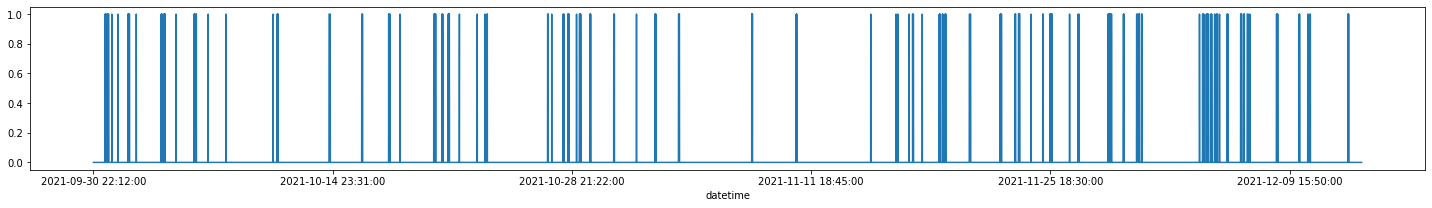

In [14]:
data1["target"].plot(figsize=(25, 3))

<AxesSubplot:xlabel='datetime'>

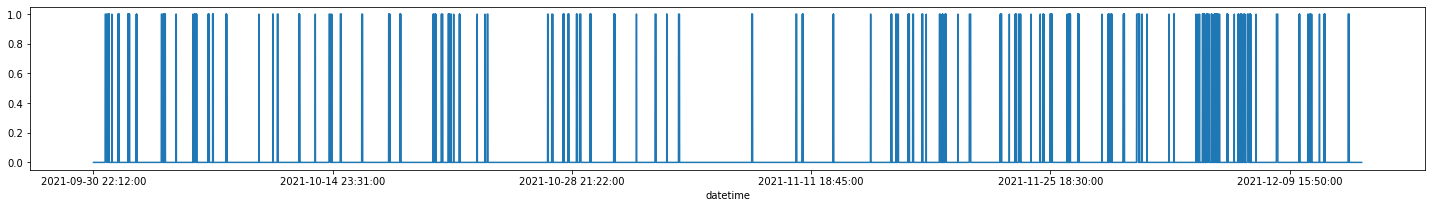

In [15]:
data2["target"].plot(figsize=(25, 3))

<AxesSubplot:xlabel='datetime'>

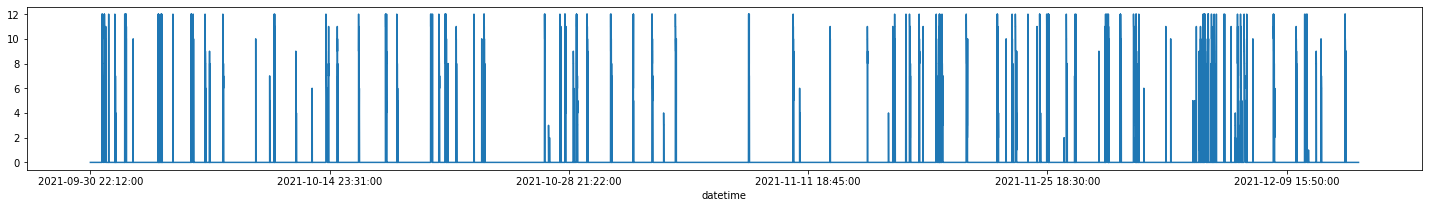

In [16]:
data3["target"].plot(figsize=(25, 3))

In [17]:
start_date = "2021-11-01 00:00"
split_date = "2021-12-01 00:00"

### Option 1

In [43]:
data1_train = data1[start_date:split_date]
data1_train = data1_train.sample(frac=1)
data1_test = data1[split_date:]

In [44]:
rf1 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456, n_jobs=-1)
rf1.fit(data1_train[selected_features].values, data1_train["target"])

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=123456)

In [45]:
predicted = rf1.predict(data1_test[selected_features].values)
accuracy = accuracy_score(data1_test["target"], predicted)
print(f'Out-of-bag score estimate: {rf1.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.982
Mean accuracy score: 0.96


In [46]:
data1_test["target"].sum()

652

In [47]:
((predicted == 1) & (data1_test["target"] == predicted)).sum()

73

In [48]:
((predicted == 1) & (data1_test["target"] != predicted)).sum()

167

In [49]:
y1.loc[split_date:, "predicted"] = predicted
loss1 = y1.loc[data1_test[(data1_test["target"] !=predicted) & (predicted==1)].index]
print('avg: {}'.format((loss1['close_t+120'] - loss1['close']).mean()))
print('min: {}'.format((loss1['close_t+120'] - loss1['close']).min()))
print('max: {}'.format((loss1['close_t+120'] - loss1['close']).max()))

avg: 42910.17964071856
min: -121000.0
max: 98000.0


In [50]:
loss1

,close,close_t+20,close_t+60,close_t+120,earn+20,earn+60,earn+120,target,predicted
datetime,,,,,,,,,
2021-12-04 16:49:00,4944000.0,5031000.0,5064000.0,4954000.0,0,1,0,0,1.0
2021-12-04 16:50:00,4956000.0,5029000.0,5050000.0,4925000.0,0,0,0,0,1.0
2021-12-04 16:51:00,4960000.0,5033000.0,5063000.0,4948000.0,0,1,0,0,1.0
2021-12-04 16:52:00,4961000.0,5030000.0,5064000.0,4948000.0,0,1,0,0,1.0
2021-12-04 16:53:00,4978000.0,5032000.0,5069000.0,4959000.0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...
2021-12-13 18:27:00,4956000.0,4956000.0,4946000.0,4965000.0,0,0,0,0,1.0
2021-12-13 18:28:00,4956000.0,4956000.0,4946000.0,4964000.0,0,0,0,0,1.0
2021-12-13 18:29:00,4961000.0,4958000.0,4945000.0,4962000.0,0,0,0,0,1.0


### Option 2

In [25]:
data2_train = data2[start_date:split_date]
data2_train = data2_train.sample(frac=1)
data2_test = data2[split_date:]

In [26]:
rf2 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456, n_jobs=-1)
rf2.fit(data2_train[selected_features].values, data2_train["target"])

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=123456)

In [27]:
predicted = rf2.predict(data2_test[selected_features].values)
accuracy = accuracy_score(data2_test["target"], predicted)
print(f'Out-of-bag score estimate: {rf2.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.966
Mean accuracy score: 0.925


In [28]:
data2_test["target"].sum()

1430

In [38]:
((predicted == 1) & (data2_test["target"] == predicted)).sum()

279

In [40]:
((predicted == 1) & (data2_test["target"] != predicted)).sum()

231

In [30]:
y2.loc[split_date:, "predicted"] = predicted
loss2 = y2.loc[data2_test[(data2_test["target"] !=predicted) & (predicted==1)].index]

In [31]:
loss2

,close,max_in_wind,max_earn_in_wind,target,clost_t+120,predicted
datetime,,,,,,
2021-12-04 14:04:00,5075000.0,5122000.0,0.009261,0,5003000.0,1.0
2021-12-04 14:05:00,5088000.0,5122000.0,0.006682,0,5000000.0,1.0
2021-12-04 14:06:00,5083000.0,5122000.0,0.007673,0,4977000.0,1.0
2021-12-04 14:07:00,5041000.0,5122000.0,0.016068,0,4957000.0,1.0
2021-12-04 14:09:00,5035000.0,5122000.0,0.017279,0,4940000.0,1.0
...,...,...,...,...,...,...
2021-12-13 18:28:00,4956000.0,4971000.0,0.003027,0,4964000.0,1.0
2021-12-13 18:29:00,4961000.0,4971000.0,0.002016,0,4962000.0,1.0
2021-12-13 19:07:00,4955000.0,4974000.0,0.003835,0,4974000.0,1.0


## Playground...

In [ ]:
# lightgbm 적용 - hyper-parameter 튜닝이 필요하다. 
train_ds = lgb.Dataset(data1_train[selected_features].values, label=data1_train["target"], feature_name=selected_features)
test_ds = lgb.Dataset(data1_test[selected_features].values, label=data1_test["target"], feature_name=selected_features)
params = {"learning_rate": 0.001,
          "max_depth": 16,
          "boosting": "gbdt",
          "objective": "binary",
          "metric": "binary_logloss",
          "is_training_metric": True,
          "num_leaves": 144,
          "feature_fraction":0.9,
          "bagging_fraction": 0.7,
          "bagging_freq": 5,
          "seed": 123456}

model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)
predicted = model.predict(data1_test[selected_features])

In [304]:
(predicted >= 0.5).astype(int).sum()

0